In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit,cross_validate

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef
from sklearn.metrics import  make_scorer,accuracy_score,precision_score,recall_score, f1_score,brier_score_loss,matthews_corrcoef
from sklearn import tree

In [2]:
#reading csv files
X_train=pd.read_csv('X_train_F.csv')
Y_train=pd.read_csv('Y_train_F.csv')
X_test=pd.read_csv('X_test_F.csv')
Y_test=pd.read_csv('Y_test_F.csv')

In [3]:
X_train= X_train[:70000]
Y_train=Y_train[:70000]

In [4]:
#SDG Classifier

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [6]:
#first standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [9]:
#lets try with first default value
clf = SGDClassifier(loss="log")
clf.fit(X_train,Y_train.values.ravel())
y_trainpredprobem=clf.predict_proba(X_train)
y_testpredprobem = clf.predict_proba(X_test)

In [10]:
#auc score with default values
print('auc of train with default parameter:',roc_auc_score(Y_train,y_trainpredprobem[:,1]))
print('auc of test with  default parameter:',roc_auc_score(Y_test,y_testpredprobem[:,1]))

auc of train with default parameter: 0.7856790204707198
auc of test with  default parameter: 0.7536223549207506


In [14]:
##GridsearchCV with Timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 5)
time_splitter_inner = TimeSeriesSplit(n_splits = 5)

model = SGDClassifier(loss="log",class_weight="balanced")
params = {
         'alpha':[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3],#learning rate
         'penalty':['l1','l2']
         }

gs_SD = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)

In [15]:
gs_SD.fit(X_train,Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   19.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.0s finished
/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SGDClassifier(class_weight='balanced', loss='log'),
             n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=10)

In [16]:
#Best parameters
gs_SD.best_params_

{'alpha': 0.01, 'penalty': 'l2'}

In [20]:
sel_ = SelectFromModel(SGDClassifier(loss="log",alpha=0.01, penalty='l2',class_weight="balanced"))
sel_.fit(scaler.transform(X_train), Y_train.values.ravel())
X_train_ = pd.DataFrame(sel_.transform(X_train))
X_test_ = pd.DataFrame(sel_.transform(X_test))

In [24]:
#test prediction with best parameters
best_SD= SGDClassifier(alpha=0.01, penalty='l2',loss="log",class_weight="balanced")
best_SD.fit(X_train_, Y_train.values.ravel())
y_trainpredbest =best_SD.predict_proba(X_train_)
y_testpredbest =best_SD.predict_proba(X_test_)
print('roc_auc:',roc_auc_score(Y_test,y_testpredbest[:,1]))
print('brier_score_loss:',brier_score_loss(Y_test,y_testpredbest[:,1]))

roc_auc: 0.74467285518714
brier_score_loss: 0.1903895034813594


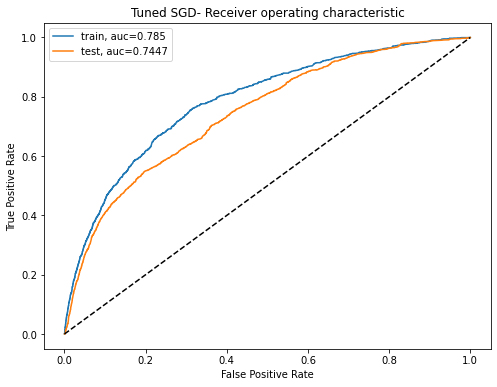

In [27]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_train,y_trainpredbest[:,1])
auc = roc_auc_score(Y_train, y_trainpredbest[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_test, y_testpredbest[:,1])
auc = roc_auc_score(Y_test,  y_testpredbest[:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD- Receiver operating characteristic')
plt.show()

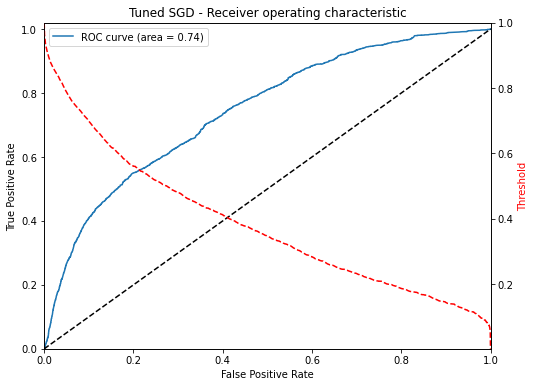

In [28]:
y_scores = y_testpredbest[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [30]:
y_testpred_ =best_SD.predict(X_test_)
print("Recall:\n",metrics.recall_score(Y_test,y_testpred_))
print("matthews_corrcoef:\n",matthews_corrcoef(Y_test, y_testpred_))

Recall:
 0.6069364161849711
matthews_corrcoef:
 0.1350170331519949


In [92]:
#LGBM

In [93]:
import lightgbm as lgb

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [94]:
clf = lgb.LGBMClassifier()
clf.fit(X_train,Y_train)

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier()

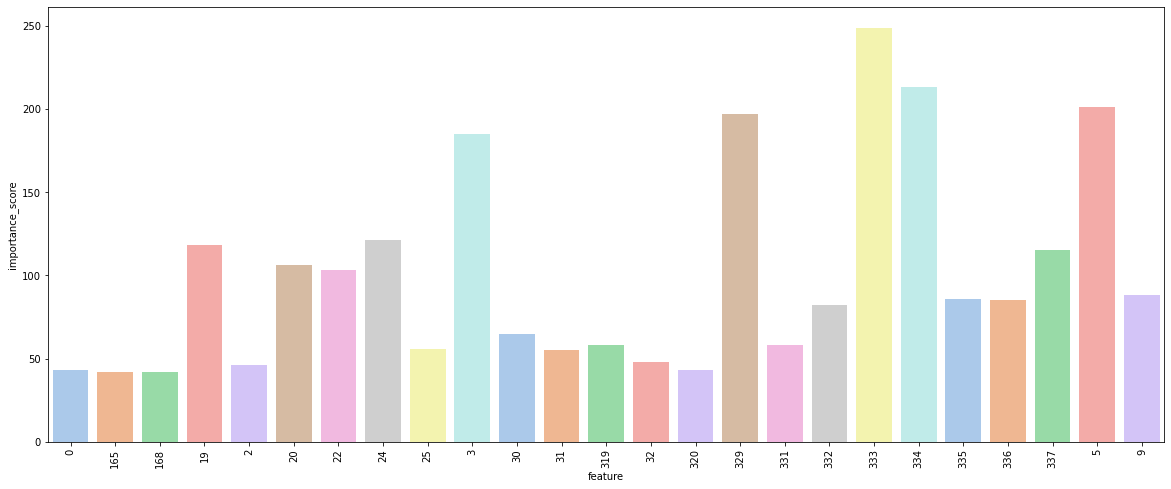

In [95]:
# visualize features with importantce score > 0
plt.figure(figsize=(20,8))
sorted_importance_lgb = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_useful_lgb = [ i for i in sorted_importance_lgb if i[1] > 0]
a, b = zip(*sorted_importance_useful_lgb)
fp = pd.DataFrame({'feature':a, 'importance_score':b})[:25]
sns.barplot(x="feature", y="importance_score", data=fp, palette = 'pastel')
plt.xticks(rotation=90)
plt.show()

(array([2., 1., 3., 3., 4., 2., 3., 0., 1., 4., 2., 0., 1., 1., 0., 1., 4.,
        1., 1., 0., 0., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  2.  ,   4.47,   6.94,   9.41,  11.88,  14.35,  16.82,  19.29,
         21.76,  24.23,  26.7 ,  29.17,  31.64,  34.11,  36.58,  39.05,
         41.52,  43.99,  46.46,  48.93,  51.4 ,  53.87,  56.34,  58.81,
         61.28,  63.75,  66.22,  68.69,  71.16,  73.63,  76.1 ,  78.57,
         81.04,  83.51,  85.98,  88.45,  90.92,  93.39,  95.86,  98.33,
        100.8 , 103.27, 105.74, 108.21, 110.68, 113.15, 115.62, 118.09,
        120.56, 123.03, 125.5 , 127.97, 130.44, 132.91, 135.38, 137.85,
        140.32, 142.79, 145.26, 147.73, 150.2 

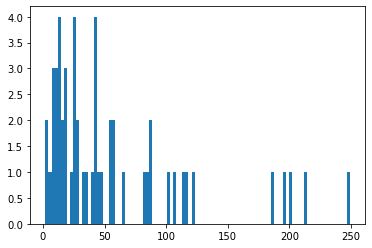

In [96]:
plt.hist(clf.feature_importances_,bins=100)

In [97]:
features = X_train.columns
importances = clf.feature_importances_
features_to_include=[]
j=0
for i in importances:
    if i>=50:
        features_to_include.append(features[j])
    j+=1

In [98]:
X_trainlgbm=X_train[features_to_include]
X_testlgbm=X_test[features_to_include]

In [99]:
X_trainlgbm.shape

(501214, 19)

In [100]:
#Data preparation for cross validation
X_trainlgbm_1=X_trainlgbm.copy()
X_testlgbm_1=X_testlgbm.copy()

train_3=pd.concat([X_trainlgbm_1,Y_train],axis=1)
test_3=pd.concat([X_testlgbm_1,Y_test],axis=1)
Data_3=pd.concat([train_3,test_3],axis=0)
Data_3= Data_3.sample(frac=1, random_state=45)

x3 = Data_3.loc[:, Data_3.columns != 'isFraud']
y3 = Data_3.loc[:,'isFraud']


In [101]:
###Resampling(SMOTE & Undersampling)
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2),
    RandomUnderSampler(sampling_strategy=0.99)           
)

In [102]:
X_trainlgbm.var()
Y_train.var()

isFraud    0.033787
dtype: float64

In [103]:
X_lgbmtrain,Y_lgbmtrain=pipe.fit_resample(X_trainlgbm,Y_train)

In [104]:
X_lgbmtrain=pd.DataFrame(X_lgbmtrain)
Y_lgbmtrain=pd.DataFrame(Y_lgbmtrain)

In [105]:
train_lgbm_=pd.concat([X_lgbmtrain,Y_lgbmtrain],axis=1)
test_lgbm_=pd.concat([X_testlgbm,Y_test],axis=1)
# Shuffle dataframe rows
trainlgbm = train_lgbm_.sample(frac=1, random_state=55)
testlgbm = test_lgbm_.sample(frac=1, random_state=55)

In [106]:
train=pd.concat([X_trainlgbm,Y_train],axis=1)
test=pd.concat([X_testlgbm,Y_test],axis=1)

In [107]:
Data=pd.concat([train,test],axis=0)

In [108]:
X_data=Data.drop('isFraud', axis=1)

In [109]:
Y_data=Data['isFraud']

In [110]:
X_lgbmtrain = trainlgbm .drop('isFraud', axis=1)
Y_lgbmtrain=trainlgbm ['isFraud']
X_lgbmtest=testlgbm.drop('isFraud', axis=1)
Y_lgbmtest=testlgbm['isFraud']

In [111]:
# with default paramter
clf = lgb.LGBMClassifier()
clf.fit(X_lgbmtrain,Y_lgbmtrain)
y_trainpred=clf.predict_proba(X_lgbmtrain)
y_testpred = clf.predict_proba(X_lgbmtest)

In [112]:
# auc with default parameters
print('train auc with default parameter:',roc_auc_score(Y_lgbmtrain,y_trainpred[:,1]))
print('test auc with default parameter:',roc_auc_score(Y_lgbmtest,y_testpred[:,1]))

train auc with default parameter: 0.97742084049652
test auc with default parameter: 0.8685362565778239


In [113]:
#  parameters currently used
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [114]:
#GridSearchCV with timeseries

folds = TimeSeriesSplit(n_splits = 3)

model=lgb.LGBMClassifier()
params = {"max_depth": [5,10,15],
              "learning_rate" : [0.1,0.15,0.3],
              "num_leaves": [32,150,200],
              "n_estimators": [500,700],
              'boost_from_average': [False],
               "random_state": [2]}

gs_lgbm = GridSearchCV(model, param_grid = params, cv = folds, scoring = 'roc_auc',verbose=10, n_jobs=-1)

In [115]:
gs_lgbm.fit(X_lgbmtrain,Y_lgbmtrain)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 10.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boost_from_average': [False],
                         'learning_rate': [0.1, 0.15, 0.3],
                         'max_depth': [5, 10, 15], 'n_estimators': [500, 700],
                         'num_leaves': [32, 150, 200], 'random_state': [2]},
             scoring='roc_auc', verbose=10)

In [116]:
#Best parameters
gs_lgbm.best_params_

{'boost_from_average': False,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 700,
 'num_leaves': 200,
 'random_state': 2}

In [117]:
#test prediction with best parameters
best_lgbm= lgb.LGBMClassifier(boost_from_average=False, learning_rate=0.1, max_depth=15, n_estimators=700,
num_leaves=200,random_state=2)
best_lgbm.fit(X_lgbmtrain, Y_lgbmtrain)
y_trainpredbest =best_lgbm.predict_proba(X_lgbmtrain)
y_testpredbest =best_lgbm.predict_proba(X_lgbmtest)
print('roc_auc:',roc_auc_score(Y_lgbmtest,y_testpredbest[:,1]))
print('brier_score_loss:',brier_score_loss(Y_lgbmtest,y_testpredbest[:,1]))

roc_auc: 0.9026505391959795
brier_score_loss: 0.028021680290951454


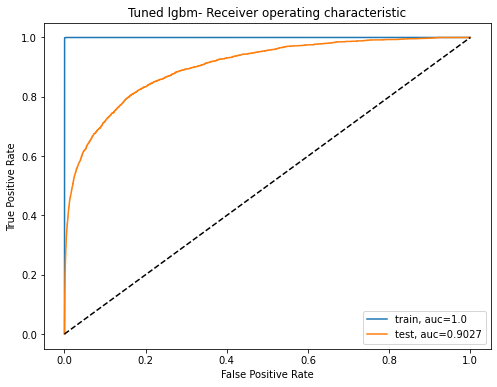

In [118]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_lgbmtrain,y_trainpredbest[:,1])
auc = roc_auc_score(Y_lgbmtrain, y_trainpredbest[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_lgbmtest, y_testpredbest[:,1])
auc = roc_auc_score(Y_lgbmtest,  y_testpredbest[:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned lgbm- Receiver operating characteristic')
plt.show()

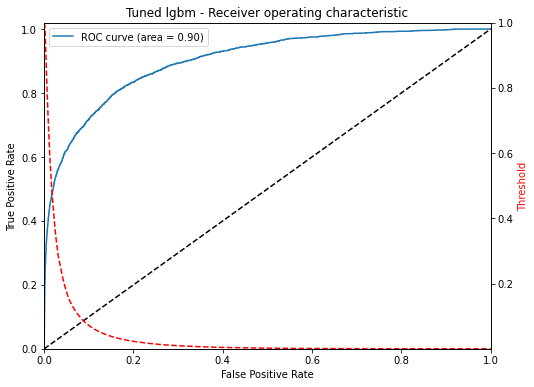

In [119]:
y_scores = y_testpredbest[:,1]
fpr, tpr, thresholds = roc_curve(Y_lgbmtest, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned lgbm - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [120]:
y_testpred_ =best_lgbm.predict(X_lgbmtest)
print("matthews_corrcoef:\n",matthews_corrcoef(Y_lgbmtest, y_testpred_))
print("Recall:\n",metrics.recall_score(Y_lgbmtest,y_testpred_))

Accuracy:
 0.9658889908873116
Recall:
 0.4765574823378292
Precision:
 0.5115477421578766
matthews_corrcoef:
 0.4761260043170554


In [121]:
x_3 = x3[:70000]
y_3 = y3[:70000]

In [122]:
#10 fold cv 
folds=TimeSeriesSplit(n_splits = 10)

In [123]:
#model with best params
model3 = lgb.LGBMClassifier(boost_from_average=False,learning_rate=0.1, max_depth=15, n_estimators=700,
 num_leaves=200,random_state=2,class_weight="balanced")

In [124]:
custom_scorer = {
                 'recall': make_scorer(recall_score, average='macro'),
                 'Brier': make_scorer(brier_score_loss),
                 'Matthewscorrcoef': make_scorer(matthews_corrcoef),
                 'ROC_AUC': make_scorer(roc_auc_score)
                 }
lgbm_scores = cross_validate(model3, x_3,y_3,cv = folds, scoring = custom_scorer)

In [125]:
sorted(lgbm_scores.keys())

['fit_time',
 'score_time',
 'test_Brier',
 'test_Matthewscorrcoef',
 'test_ROC_AUC',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [126]:
lgbm_recall = lgbm_scores['test_recall']
lgbm_Brier = lgbm_scores['test_Brier']
lgbm_Matthewscorrcoef = lgbm_scores['test_Matthewscorrcoef']
lgbm_ROC_AUC = lgbm_scores['test_ROC_AUC']

In [127]:
print("=== All recall Scores ===")
print(lgbm_recall)
print("=== All Brier Scores ===")
print(lgbm_Brier)
print("=== All Matthewscorrcoef Scores ===")
print(lgbm_Matthewscorrcoef)
print("=== All ROC_AUC Scores ===")
print(lgbm_ROC_AUC)

=== All accuracy Scores ===
[0.97234009 0.96935408 0.97579758 0.97516895 0.97218293 0.97265441
 0.97123998 0.97375452 0.97485463 0.97721201]
=== All precision Scores ===
[0.84850615 0.79600868 0.84032464 0.83697349 0.84948898 0.88274296
 0.89437783 0.9113385  0.89955286 0.91339942]
=== All recall Scores ===
[0.63328305 0.60797091 0.69176805 0.64797505 0.66213466 0.70142135
 0.67366268 0.67537185 0.68297817 0.73995182]
=== All f1 Scores ===
[0.68947549 0.65479025 0.74379932 0.70321548 0.71887082 0.76157249
 0.73772663 0.74251157 0.74814961 0.80182139]
=== All Brier Scores ===
[0.02765991 0.03064592 0.02420242 0.02483105 0.02781707 0.02734559
 0.02876002 0.02624548 0.02514537 0.02278799]
=== All Matthewscorrcoef Scores ===
[0.43104507 0.35754904 0.51093401 0.44660349 0.47608518 0.55531109
 0.52340696 0.53716737 0.54077519 0.62990775]
=== All ROC_AUC Scores ===
[0.63328305 0.60797091 0.69176805 0.64797505 0.66213466 0.70142135
 0.67366268 0.67537185 0.68297817 0.73995182]


In [128]:
print("=== Mean recall Score ===")
print( lgbm_recall.mean())
print("=== Mean Brier Score ===")
print( lgbm_Brier.mean())
print("=== Mean Matthewscorrcoef  Score ===")
print( lgbm_Matthewscorrcoef .mean())
print("=== Mean ROC_AUC  Score ===")
print( lgbm_ROC_AUC .mean())

=== Mean accuracy Score ===
0.9734559170202735
=== Mean precision Score ===
0.8672713522110804
=== Mean recall Score ===
0.6716517591536031
=== Mean f1 Score ===
0.7301933054014462
=== Mean Brier Score ===
0.026544082979726547
=== Mean Matthewscorrcoef  Score ===
0.5008785158745546
=== Mean ROC_AUC  Score ===
0.6716517591536031


In [129]:
print("=== Maximum recall Score ===")
print( lgbm_recall.max())
print("=== Minimum Brier Score ===")
print( lgbm_Brier.min())
print("=== Maximum Matthewscorrcoef  Score ===")
print( lgbm_Matthewscorrcoef .max())
print("=== Maximum ROC_AUC  Score ===")
print( lgbm_ROC_AUC .max())

=== Maximum accuracy Score ===
0.9772120069149772
=== Maximum precision Score ===
0.9133994245933582
=== Maximum recall Score ===
0.7399518210027765
=== Maximum f1 Score ===
0.8018213869699821
=== Minimum Brier Score ===
0.022787993085022787
=== Maximum Matthewscorrcoef  Score ===
0.6299077543027272
=== Maximum ROC_AUC  Score ===
0.7399518210027765
